In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import itertools
import matplotlib.ticker as mticker
from scipy.optimize import brentq, curve_fit
from mpmath import zeta
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl  
from scipy.optimize import brentq, curve_fit
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def func(x, a):
    return a*x


font = {'weight': 'normal', 'family': 'DejaVu Sans'}
plt.rc('text', usetex = True)
plt.rc('font', **font)
plt.rcParams['font.size'] = 24


def format_power(x):
    
    power = int("{:.2e}".format(x).split('e')[1])
    val = float("{:.2e}".format(x).split('e')[0])
    
    return r'%.2f \cdot 10^{%d}' % (val, power)


def load_data_lifetime():
    
    data = np.load('popdyn_scaling_dimlifetime_data.npz', 
                    allow_pickle = True)
    
    return (data['sigvar'], data['q'], data['params'],
            data['alphas'], data['nu'], data['gamma'])

def load_data_size():
    
    data = np.load('popdyn_scaling_dimsize_data.npz', 
                    allow_pickle = True)
    
    return (data['sigvar'], data['q'], data['params'],
            data['betas'], data['nu'], data['gamma'])

def load_data_briney():
    
    data = np.load('powerlaw_briney_data.npz', 
                    allow_pickle = True)
    
    return (data['people'], data['sizes'], data['size_hists'],
            data['betas'], data['betas_upper'], data['betas_lower'])



def save_fig(figs, figname):

    if (type(figs) is list):
        for q, fig in enumerate(figs):
            fig.savefig('%s_%d.svg' % (figname, q), bbox_inches = 'tight')
            fig.savefig('%s_%d.pdf' % (figname, q), bbox_inches = 'tight')
            fig.savefig('%s_%d.png' % (figname, q), bbox_inches = 'tight', dpi = 300)
    else:
        figs.savefig('%s.svg' % (figname), bbox_inches = 'tight')
        figs.savefig('%s.pdf' % (figname), bbox_inches = 'tight')
        figs.savefig('%s.png' % (figname), bbox_inches = 'tight', dpi = 300)

def set_size(w,h,ax):
    Bbox = ax.get_position()
        
    l = Bbox.x0
    r = Bbox.x1
    t = Bbox.y1
    b = Bbox.y0

    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

No handles with labels found to put in legend.


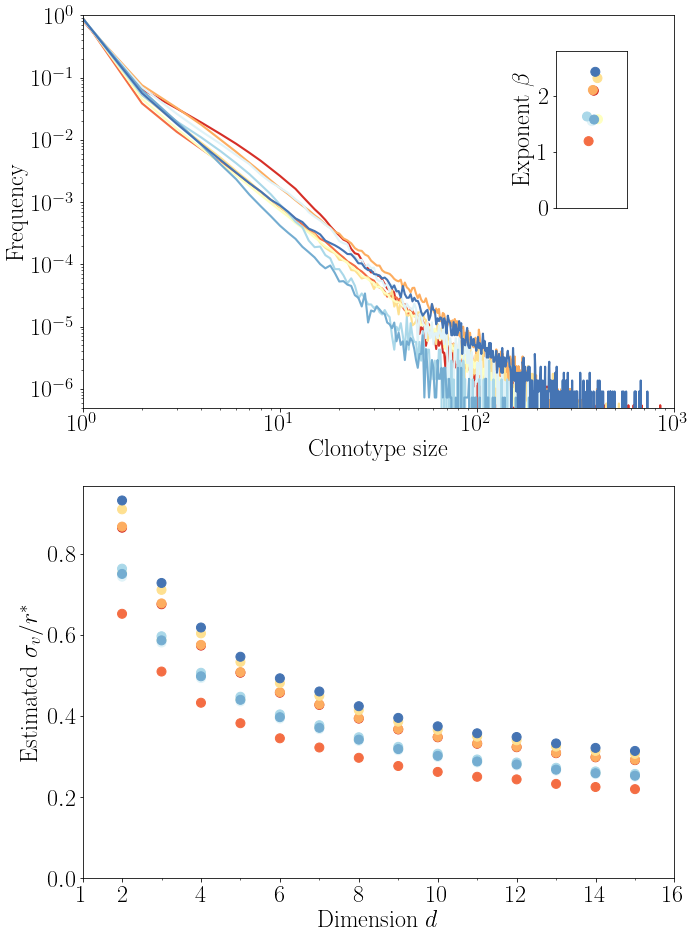

In [17]:
colors = itertools.cycle(sns.color_palette("flare", n_colors = 4))
j0 = np.array([(np.pi)/2, 2.4048, np.pi, 3.83171, 4.49341, 5.13562, 5.76346, 6.38016, 6.98793, 7.58834,
               8.1825, 8.7714, 9.3558, 9.9361, 10.5128, 11.0863, 11.6570, 12.2250, 12.7907, 13.3543])

fig = plt.figure() #11.6

gs = gridspec.GridSpec(nrows = 2, ncols = 1, height_ratios=[1, 1])
ax_plaw = fig.add_subplot(gs[0])
set_size(1.5*5.48, 1.2*4.54, ax_plaw)

(sigvar, q, params,
 betas, nu, gamma) = load_data_size()
nparams = len(params)

Gamma = gamma*(1 + nu)
u = np.log(Gamma)
r_star = np.log(gamma*nu/(1 - gamma))**(1/q)

slopes = np.zeros(nparams)

for j in range(nparams):

    dim = params[j]
    _sigvar = sigvar*j0[1]**2/2/(j0[dim - 1]**2/dim)
    slopes[j], _ = curve_fit(func, (_sigvar[:]/r_star)**2/(u), betas[j,:] - 1)

(people, sizes, size_hists, 
 betas, _, _,) = load_data_briney()
npeople = len(people)

color_cycle = itertools.cycle(sns.color_palette("RdYlBu", n_colors = npeople))

colors = []

#perm = np.random.permutation(list(range(npeople))).astype(int)
perm = [0, 6, 7, 4, 5, 2, 3, 8, 1]
#perm = [3, 1, 6, 8, 0, 2, 4, 5, 7]
size_hists = size_hists[perm]
people = people[perm]
betas = betas[perm]
sizes = sizes[perm]

for i in perm:

    color = next(color_cycle)
    hist, center = size_hists[i]
    ax_plaw.loglog(center, hist,  '-', linewidth = 2.1, color = color, label = r'%s' % people[i])
    colors.append(color)
    
#ax_plaw.legend(title = 'Donors', frameon = False)
ax_plaw.set_xlabel('Clonotype size')
ax_plaw.set_ylabel('Frequency')
ax_plaw.set_ylim([5*1e-7, 1])
ax_plaw.set_xlim([1, 1e3])
#ax_plaw.set_title(r'IgG repertoires', pad = -60, y=1.000001)

axins = inset_axes(ax_plaw,
                   width="12%",
                   height="40%",
                   loc = 'upper right',
                   bbox_to_anchor =  (-0.06, -0.06, 1., 1.),
                   bbox_transform = ax_plaw.transAxes)

x_jitter = np.random.uniform(-0.2, 0.2, size = len(betas))

axins.scatter([0]*npeople + x_jitter, betas - 1,
              s = 9**2, c = colors)
axins.set_xticks([])
axins.set_xlim([-1, 1])
axins.set_ylim(ymin = 0, ymax = 2.8)
axins.yaxis.set_major_locator(MultipleLocator(1))
axins.set_ylabel(r'Exponent $\beta$')
#ax_fake = fig.add_subplot(gs[1])
#ax_fake.axis('off')

ax_predict = fig.add_subplot(gs[1])
sigv_equiv = np.zeros((nparams, npeople))
u_equiv = np.log(1.4)

for i in perm:
    
    for j in range(nparams):
        
        dim = params[j]
        sigv_equiv[j,i] = np.sqrt(u_equiv*(betas[i] - 1)/slopes[j])
        


slope_fit, offset = np.polyfit(j0[params - 1]**2/params, slopes, 1)


dim_equiv = np.tile(params, (npeople, 1)).T
temp = np.tile(betas, (nparams, 1))

x_jitter = np.random.uniform(-0.0, 0.0, size = len(dim_equiv.flatten()))

a = ax_predict.scatter(x = dim_equiv.flatten() + x_jitter, y = sigv_equiv.flatten(), 
                     s = 9**2, c = colors*nparams, marker = 'o')


fig.canvas.draw()
xticks = list(ax_predict.get_xticks())
xticks_labels = [w.get_text() for w in ax_predict.get_xticklabels()]

xticks_labels += [1]
xticks += [1]

ax_predict.set_xticks(xticks)
ax_predict.set_xticklabels(xticks_labels)


ax_predict.set_ylabel(r'Estimated $\sigma_v/r^*$')
ax_predict.set_xlabel(r'Dimension $d$')

ax_predict.set_ylim(ymin = 0)
ax_predict.set_xlim(xmin = 1, xmax = 16)
ax_predict.legend(frameon = False)

ax_predict.xaxis.set_minor_locator(MultipleLocator(1))

plt.show()

save_fig(fig, 'fig4')